Set enviromnetal variables

In [1]:
#%env PyFLEXTRKR_LIB_DIR=/home/dragomir/University_Stuff/Thesis/Python_work

Import required functions and libraries

In [2]:
import numpy as np
import netCDF4 as nc
import time
from Helper_fun import time_intersection, generate_temp_range
from data_regrid import Projection_transformer, output_file_generator_remap
import os
import pyproj

from pyresample.geometry import SwathDefinition
import pyresample.kd_tree as kd_tree
from pyresample import get_area_def
import xarray as xr

# ==================================================
# Create a merged file that includes the cph field
# ==================================================

PyFLEXTRKR_LIB_DIR = os.environ['PyFLEXTRKR_LIB_DIR']


Define output file class

Data filtering

In [3]:
# ==================================================
# Filtering and formatting data
# ==================================================


def filter_data(ctt, cph, min_temp, max_temp):
    # Filter by temperature range -38C<T<0C
    ctt = np.ma.masked_where((ctt < 273.15 + min_temp)
                             | (ctt > 273.15 + max_temp), ctt)
    # Create a combined mask that only has entries at positions within temp range and valid phase
    cph_filtered = cph.copy()
    cph_filtered.mask = ctt.mask | cph.mask

    return cph_filtered


Main

In [4]:
# Set up timer
start_time = time.time()

# ==================================================
# Open and load cloud top temp and cloud top phase data
# ==================================================

print("Loading data")
cph_fp = PyFLEXTRKR_LIB_DIR+f'/TEST/example_preprocessing/cph_resampled_new_grid_1.nc'
tmp_fp = PyFLEXTRKR_LIB_DIR+f'/TEST/example_preprocessing/ctt_resampled_new_grid_1.nc'
cph_data = nc.Dataset(cph_fp)  # cloud_phase_file
tmp_data = nc.Dataset(tmp_fp)  # cloud_phase_file
print(f"Data loaded. Elapsed time: {time.time()-start_time}")


# ==================================================
# ==================================================


Loading data
Data loaded. Elapsed time: 0.13479924201965332


In [5]:
# ==================================================
# Load axices
# ==================================================

print(f"Setting up dimentions")

# Space dimentions
# ==================================================
x = tmp_data['lon'][:]
y = tmp_data['lat'][:]

# Transformer=Projection_transformer()
# Transformer.generate_lat_lon_prj(cph_data)

# Limit data to a time period



# Generate lat and lon matrices
# lon_mat = np.ones((len(lat_limited_ind), len(x)))*(x.T * 10 * 180 / np.pi)
# lat_mat = np.ones((len(lat_limited_ind), len(x))) * \
#     (y[lat_limited_ind]*10*180/np.pi)[:, None]

# Time dimension
# ==================================================

# Get time intersection
time_ind_ctt, time_ind_cph = time_intersection(
    tmp_data['time'], cph_data['time'])

# Extract time variable for later use
# assuming the time variable is named 'time'
time_var = cph_data.variables['time']
time_units = time_var.units
calendar = time_var.calendar if hasattr(time_var, 'calendar') else 'standard'

# Convert time steps to dates using netCDF num2date
dates = nc.num2date(time_var[:], units=time_units, calendar="gregorian")

print(f"Dimentions set. Elapsed time: {time.time()-start_time}")


# ==================================================
# ==================================================



Setting up dimentions
Dimentions set. Elapsed time: 0.26702451705932617


Load and Transform initial data

In [6]:
tmp_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 2.2.4 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Sat Nov 09 04:37:17 2024: cdo setgrid,/cluster/work/climate/dnikolo/n2o/TEST/targetgrid.txt ctt_resampled.nc ctt_resampled_new_grid_1.nc
    CDO: Climate Data Operators version 2.2.2 (https://mpimet.mpg.de/cdo)
    dimensions(sizes): time(24), lon(3712), lat(3712)
    variables(dimensions): float64 time(time), float64 lon(lon), float64 lat(lat), int16 cph(time, lat, lon)
    groups: 

In [7]:
print("Loading copies of data")
# Get reduced data arrays ctt and cph
ctt = tmp_data['cph'][time_ind_ctt, :, :] #TODO: FIX VARIABLE NAMING
cph = cph_data['cph'][time_ind_cph, :, :]
# [2,5,10,15,38]
# ctt=Transformer.remap_data(ctt)
# cph=Transformer.remap_data(cph)

Loading copies of data


Limit data to a region between 50 and 70 deg latitude and -60 60 longitude

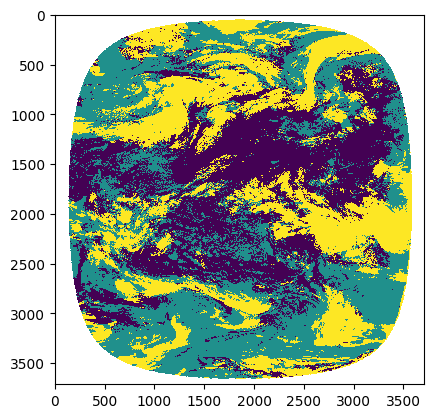

In [8]:
import matplotlib.pyplot as plt 
plt.imshow(cph[1,:,:], interpolation='none')

In [9]:
 
# lat_limited_ind = np.where((y>=-70) & (y<=-50))[0]
# lon_limited_ind = np.where((x>=-60) & (x<=60))[0]
lat_limited_ind=np.arange(len(y))
lon_limited_ind=np.arange(len(x))
lat_limited_ind_bug = tuple(lat_limited_ind)
lon_limited_ind_bug = tuple(lon_limited_ind)

# Use np.ix_ to create a meshgrid of indices
lat_lon_index = np.ix_(lat_limited_ind, lon_limited_ind)

# Apply the index
ctt_target_reg = ctt[:, lat_lon_index[0], lat_lon_index[1]]
cph_target_reg  = cph[:, lat_lon_index[0], lat_lon_index[1]]
lon_limited_ind


array([   0,    1,    2, ..., 3709, 3710, 3711])

0.19498780167769025


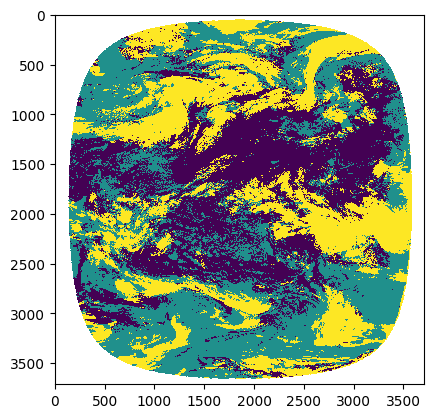

In [10]:
cph_plot=cph_target_reg[1,:,:]
print(np.ma.count_masked(cph_plot)/cph_plot.size)
plt.imshow(cph_plot, interpolation='none')

In [11]:
['avg_lat']
# ==================================================
# Filter data and generate new files
# ==================================================


t_deltas = [2,5 ,10,15,38]  # [2,5 ,10,15,38]
temp_bounds = generate_temp_range(t_deltas)
file_write_time=time.time()
new_dataset = xr.open_dataset(cph_fp)#, 'r+')
for i in range(temp_bounds[0].shape[0]):
    min_temp = temp_bounds[0][i]
    max_temp = temp_bounds[1][i]
    cph_filtered = filter_data(ctt_target_reg, cph_target_reg, min_temp, max_temp)
    print(f"Generating new merged file: T={min_temp}:{max_temp}")
    # cph_data, var_field, lat_limited_ind, lon_limited_ind, dates, time_ind, time_units, calendar, new_file_name, Transformer
    date=dates[0]
    new_fp = PyFLEXTRKR_LIB_DIR + \
        f"/TEST/example_preprocessing/WG-T-{round(abs(min_temp))}-{round(abs(max_temp))}-agg-1-{date.day:02d}-{date.month:02d}-{date.year}_{date.hour:02d}:{date.minute:02d}:{date.second:02d}.nc"
    
    # shutil.copyfile(cph_fp, new_fp)
    
    new_dataset['cph'] = (("time","lat","lon"),cph_filtered.filled(fill_value=0))
    new_dataset.to_netcdf(new_fp)
    # output_file_generator_remap(cph_data, 
    #     cph_filtered.filled(fill_value=0),  lon_limited_ind, lat_limited_ind, dates,time_ind_cph,time_units, calendar , new_file_name, x,y)#cph_filtered.filled(fill_value=0)
    print(
        f"New merged file generated and saved. Elapsed filew writing time {time.time()-file_write_time}")
           

Generating new merged file: T=-2:0
New merged file generated and saved. Elapsed filew writing time 9.137309789657593
Generating new merged file: T=-4:-2
New merged file generated and saved. Elapsed filew writing time 14.505522966384888
Generating new merged file: T=-6:-4
New merged file generated and saved. Elapsed filew writing time 19.868961095809937
Generating new merged file: T=-8:-6
New merged file generated and saved. Elapsed filew writing time 25.2846941947937
Generating new merged file: T=-10:-8
New merged file generated and saved. Elapsed filew writing time 30.70489478111267
Generating new merged file: T=-12:-10
New merged file generated and saved. Elapsed filew writing time 36.11520004272461
Generating new merged file: T=-14:-12
New merged file generated and saved. Elapsed filew writing time 41.46151661872864
Generating new merged file: T=-16:-14
New merged file generated and saved. Elapsed filew writing time 46.87277412414551
Generating new merged file: T=-18:-16
New merged 